In [1]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import (
    Dataset,
    DataLoader
)
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.preprocessing import LabelBinarizer
from torch.optim.optimizer import Optimizer, required
from torchvision.transforms import (
    RandomResizedCrop,
    ColorJitter,
    RandomApply,
    Compose,
    GaussianBlur,
    ToTensor,
)
import torchvision.models as models
import os
import time
from sklearn.model_selection import train_test_split as tts
import numpy as np
from tqdm.cli import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def get_complete_transform(output_shape, kernel_size, s=1.0):
    """
    The color distortion transform.
    
    Args:
        s: Strength parameter.
    
    Returns:
        A color distortion transform.
    """
    rnd_crop = RandomResizedCrop(output_shape)    
    color_jitter = ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = RandomApply([color_jitter], p=0.8)
    gaussian_blur = GaussianBlur(kernel_size=kernel_size)
    rnd_gaussian_blur = RandomApply([gaussian_blur], p=0.5)
    to_tensor = ToTensor()
    image_transform = Compose([
        to_tensor,
        rnd_crop,
        rnd_color_jitter,
        rnd_gaussian_blur,
    ])
    return image_transform

In [3]:
class ContrastiveLearningViewGenerator(object):
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        views = [self.base_transform(x) for i in range(self.n_views)]
        return views

In [4]:
class Pretrain_Dataset(Dataset):
    def __init__(self, dataset, transform=None):
        """
        Args:
            list_images (list): List of all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.list_images_path, _ = dataset['path'], dataset['class']
        self.transform = transform

    def __len__(self):
        return len(self.list_images_path)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = np.load(self.list_images_path.iloc[idx])
        image = np.nan_to_num(image, nan=0)
        image = np.stack((image,) * 3, axis=0)
        image = np.reshape(image, (334, 334, 3))
        if self.transform:
            image = self.transform(image)
        return image

In [5]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

class SimCLR(nn.Module):
    def __init__(self, linear_eval=False):
        super().__init__()
        self.linear_eval = linear_eval
        resnet18 = models.resnet18(pretrained=False)
        resnet18.fc = Identity()
        self.encoder = resnet18
        self.projection = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 128)
        )
    def forward(self, x):
        if not self.linear_eval:
            x = torch.cat(x, dim=0)
        
        encoding = self.encoder(x)
        projection = self.projection(encoding) 
        return projection
    
class LinearEvaluation(nn.Module):
    def __init__(self, model, nu_classes):
        super().__init__()
        simclr = model
        simclr.linear_eval = True
        simclr.projection = Identity()
        self.simclr = simclr
        for param in self.simclr.parameters():
            param.requires_grad = False
        self.linear = nn.Linear(512, nu_classes)

    def forward(self, x):
        encoding = self.simclr(x)
        pred = self.linear(encoding) 
        return pred    

In [6]:
def cont_loss(features, temp):
    """
    The NTxent Loss.
    
    Args:
        z1: The projection of the first branch
        z2: The projeciton of the second branch
    
    Returns:
        the NTxent loss
    """
    similarity_matrix = torch.matmul(features, features.T) # 128, 128
    # discard the main diagonal from both: labels and similarities matrix
    mask = torch.eye(LABELS.shape[0], dtype=torch.bool).to(DEVICE)
    # ~mask is the negative of the mask
    # the view is required to bring the matrix back to shape
    labels = LABELS[~mask].view(LABELS.shape[0], -1) # 128, 127
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1) # 128, 127

    # select and combine multiple positives
    positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1) # 128, 1

    # select only the negatives
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1) # 128, 126

    logits = torch.cat([positives, negatives], dim=1) # 128, 127
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(DEVICE)

    logits = logits / temp
    return logits, labels

In [7]:
EETA_DEFAULT = 0.001
class LARS(Optimizer):
    """
    Layer-wise Adaptive Rate Scaling for large batch training.
    Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
    I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)
    """

    def __init__(
        self,
        params,
        lr=required,
        momentum=0.9,
        use_nesterov=False,
        weight_decay=0.0,
        exclude_from_weight_decay=None,
        exclude_from_layer_adaptation=None,
        classic_momentum=True,
        eeta=EETA_DEFAULT,
    ):
        """Constructs a LARSOptimizer.
        Args:
        lr: A `float` for learning rate.
        momentum: A `float` for momentum.
        use_nesterov: A 'Boolean' for whether to use nesterov momentum.
        weight_decay: A `float` for weight decay.
        exclude_from_weight_decay: A list of `string` for variable screening, if
            any of the string appears in a variable's name, the variable will be
            excluded for computing weight decay. For example, one could specify
            the list like ['batch_normalization', 'bias'] to exclude BN and bias
            from weight decay.
        exclude_from_layer_adaptation: Similar to exclude_from_weight_decay, but
            for layer adaptation. If it is None, it will be defaulted the same as
            exclude_from_weight_decay.
        classic_momentum: A `boolean` for whether to use classic (or popular)
            momentum. The learning rate is applied during momeuntum update in
            classic momentum, but after momentum for popular momentum.
        eeta: A `float` for scaling of learning rate when computing trust ratio.
        name: The name for the scope.
        """

        self.epoch = 0
        defaults = dict(
            lr=lr,
            momentum=momentum,
            use_nesterov=use_nesterov,
            weight_decay=weight_decay,
            exclude_from_weight_decay=exclude_from_weight_decay,
            exclude_from_layer_adaptation=exclude_from_layer_adaptation,
            classic_momentum=classic_momentum,
            eeta=eeta,
        )

        super(LARS, self).__init__(params, defaults)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.use_nesterov = use_nesterov
        self.classic_momentum = classic_momentum
        self.eeta = eeta
        self.exclude_from_weight_decay = exclude_from_weight_decay
        # exclude_from_layer_adaptation is set to exclude_from_weight_decay if the
        # arg is None.
        if exclude_from_layer_adaptation:
            self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
        else:
            self.exclude_from_layer_adaptation = exclude_from_weight_decay

    def step(self, epoch=None, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            eeta = group["eeta"]
            lr = group["lr"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                param = p.data
                grad = p.grad.data

                param_state = self.state[p]

                # TODO: get param names
                # if self._use_weight_decay(param_name):
                grad += self.weight_decay * param

                if self.classic_momentum:
                    trust_ratio = 1.0

                    # TODO: get param names
                    # if self._do_layer_adaptation(param_name):
                    w_norm = torch.norm(param)
                    g_norm = torch.norm(grad)

                    device = g_norm.get_device()
                    trust_ratio = torch.where(
                        w_norm.gt(0),
                        torch.where(
                            g_norm.gt(0),
                            (self.eeta * w_norm / g_norm),
                            torch.Tensor([1.0]).to(device),
                        ),
                        torch.Tensor([1.0]).to(device),
                    ).item()

                    scaled_lr = lr * trust_ratio
                    if "momentum_buffer" not in param_state:
                        next_v = param_state["momentum_buffer"] = torch.zeros_like(
                            p.data
                        )
                    else:
                        next_v = param_state["momentum_buffer"]

                    next_v.mul_(momentum).add_(scaled_lr, grad)
                    if self.use_nesterov:
                        update = (self.momentum * next_v) + (scaled_lr * grad)
                    else:
                        update = next_v

                    p.data.add_(-update)
                else:
                    raise NotImplementedError

        return loss

In [8]:
def pretraining(dataset, config,):
    train_dl = DataLoader(dataset,
                    batch_size=config.BATCH_SIZE,
                    shuffle=True)
    
    simclr_model = SimCLR().to(DEVICE)
    criterion = nn.CrossEntropyLoss().to(DEVICE)
    optim = LARS(
            [params for params in simclr_model.parameters() if params.requires_grad],
            lr=0.01,
            weight_decay=1e-6,
            exclude_from_weight_decay=["batch_normalization", "bias"],
            )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, 10, eta_min=0, last_epoch=-1, verbose='deprecated')
    EPOCHS = config.EPOCHS
    best_model = simclr_model
    best_loss = np.inf
    for epoch in range(EPOCHS):
        t0 = time.time()
        running_loss = 0.0
        for views in tqdm(train_dl, total = len(train_dl)):
            projections = simclr_model([view.to(DEVICE) for view in views])
            logits, labels = cont_loss(projections, temp=2)
            loss = criterion(logits, labels)
            loss.backward()
            optim.step()
            # print statistics
            running_loss += loss.item()
        scheduler.step()
        if best_loss > running_loss:
            best_loss = running_loss
            best_model = simclr_model
            print("best model saved")
        print(f'EPOCH: {epoch+1} LOSS: {(running_loss):.4f} ')
        print(f'Time taken: {((time.time()-t0)/60):.3f} mins')
    return best_model

In [9]:
data = os.listdir("/home/jainvaibhav/Vaibhav_Jain/gsoc/real_hst")
non_lenses = [file for file in data if file.startswith('nl')]
strong_lenses = [file for file in data if file not in non_lenses]

output_shape = [224,224]
kernel_size = [21,21] # 10% of the output_shape

df_non = pd.DataFrame(columns=['path', 'class'])
df_non['path'] = '/home/jainvaibhav/Vaibhav_Jain/gsoc/real_hst/' + pd.Series(non_lenses)
df_non['class'] = 0

df_st = pd.DataFrame(columns=['path', 'class'])
df_st['path'] = '/home/jainvaibhav/Vaibhav_Jain/gsoc/real_hst/' + pd.Series(strong_lenses)
df_st['class'] = 1

combined_df = pd.concat([df_non, df_st], ignore_index=True)
train_df, temp_df = tts(combined_df, test_size = 0.4, random_state = 42, shuffle = True)
val_df, test_df = tts(temp_df, test_size = 0.25, random_state = 42, shuffle = True)
#train: 60, val:30, test:10

In [10]:
class pretrain_config:
    BATCH_SIZE = train_df.shape[0]
    EPOCHS = 20

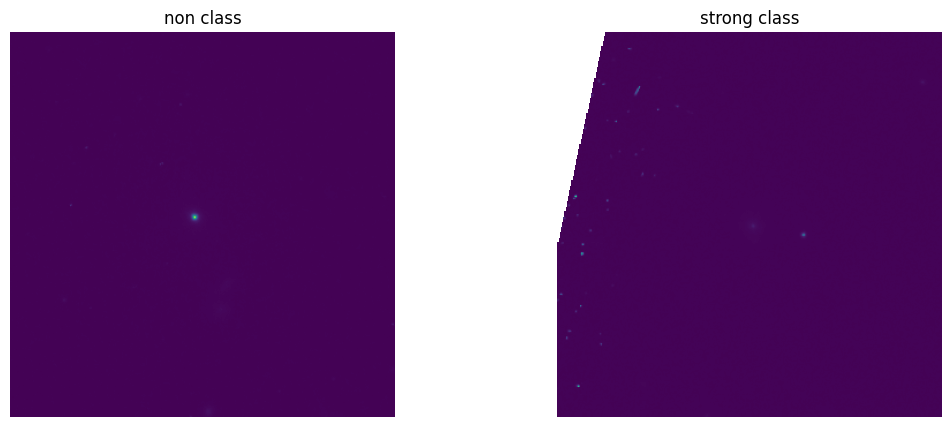

In [11]:
img_non = np.load(df_non['path'][0])
img_strong = np.load(df_st['path'][0])

fig = plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_non)  # Assuming grayscale image, adjust cmap as needed
plt.title('non class')
plt.axis('off')  # Turn off axis

plt.subplot(1, 3, 2)
plt.imshow(img_strong)  # Assuming grayscale image, adjust cmap as needed
plt.title('strong class')
plt.axis('off')  # Turn off axis

plt.show()

In [ ]:
LABELS = torch.cat([torch.arange(pretrain_config.BATCH_SIZE) for i in range(2)], dim=0)
LABELS = (LABELS.unsqueeze(0) == LABELS.unsqueeze(1)).float() # Creates a one-hot with broadcasting
LABELS = LABELS.to(DEVICE)

base_transforms = get_complete_transform(output_shape=output_shape, kernel_size=kernel_size, s=1.0)
custom_transform = ContrastiveLearningViewGenerator(base_transform=base_transforms)

train_ds = Pretrain_Dataset(dataset = train_df, transform=custom_transform)
model = pretraining(train_ds,config=pretrain_config)
torch.save(model.state_dict(),'model_pretraining_weights.pth')

In [ ]:
class train_config:
    BATCH_SIZE = 16
    EPOCHS = 20
    criterion = nn.CrossEntropyLoss().to(DEVICE)
    
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

def plot_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()  
    
class Train_Dataset(Dataset):
    def __init__(self, dataset, transform=None):
        """
        Args:
            list_images (list): List of all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.list_images, self.list_labels = dataset['path'], dataset['class']
        self.transform = transform

    def __len__(self):
        return len(self.list_images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = np.load(self.list_images.iloc[idx])
        label = self.list_labels.iloc[idx]
        image = np.nan_to_num(image, nan=0)
        image = np.stack((image,) * 3, axis=0)
        if self.transform:
            image = self.transform(image)
        return image, label
    

    
def training(dataset, val_dataset, train_config):
    train_dl = DataLoader(dataset,
                    batch_size=train_config.BATCH_SIZE,
                    shuffle=False,
                    num_workers=os.cpu_count(), 
                    drop_last=True,
                    pin_memory=True,)
    
    val_dl = DataLoader(val_dataset,
                    batch_size = 1,
                    shuffle=False,
                    num_workers=os.cpu_count(), 
                    drop_last=True,
                    pin_memory=True,)
    
    EPOCHS = train_config.EPOCHS
    model = SimCLR().to(DEVICE)
    model.load_state_dict(torch.load("/home/jainvaibhav/Vaibhav_Jain/gsoc/model_pretraining_weights.pth"))  
    nu_classes = 2
    best_metric = 0
    eval_model = LinearEvaluation(model, nu_classes).to(DEVICE)
    best_model = eval_model
    optimizer = torch.optim.AdamW(eval_model.parameters(), lr = 1e-4)
    softmax = nn.Softmax(dim=1)  # Softmax activation
    for epoch in range(EPOCHS):
        t0 = time.time()
        running_loss = 0.0
        true_labels = []
        predicted = []        
        eval_model.train()
        for element in tqdm(train_dl, total = len(train_dl),desc="Training"):
            image, label = element
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            pred = eval_model(image)
            loss = train_config.criterion(pred, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
                    
        eval_model.eval()
        for element in tqdm(val_dl, total = len(val_dl),desc="Validating"):
            image, label = element
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            pred = eval_model(image)
            pred = softmax(pred)
            _ , predicted_class_index = torch.max(pred, dim=1)
            true_labels.extend(label.cpu().numpy())
            predicted.extend(predicted_class_index.cpu().detach().numpy())
            
        roc_auc  = multiclass_roc_auc_score(true_labels, predicted)             
        print(f'EPOCH: {epoch+1} TRAIN LOSS: {(running_loss/100):.4f} VAL ROC AUC: {(roc_auc):.4f} ')
        if best_metric < roc_auc:
            best_metric = roc_auc
            best_model = eval_model
            print('best model saved')
        print(f'Time taken: {((time.time()-t0)/60):.3f} mins')
    return best_model, best_metric
 
def Testing(model, test_dataset):
    true_labels = []
    predicted = []          
    model.eval()
    softmax = nn.Softmax(dim=1)  # Softmax activation
    val_dl = DataLoader(test_dataset,
                        batch_size = train_config.BATCH_SIZE,
                        shuffle=False,
                        num_workers=os.cpu_count(), 
                        drop_last=True,
                        pin_memory=True,)

    for element in tqdm(val_dl, total = len(val_dl),desc="Testing"):
        image, label = element
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        pred = model(image)
        pred = softmax(pred)
        _ , predicted_class_index = torch.max(pred, dim=1)
        true_labels.extend(label.cpu().numpy())
        predicted.extend(predicted_class_index.cpu().detach().numpy())
    plot_roc_curve(true_labels, predicted)

In [ ]:
val_ds = Train_Dataset(val_df)
test_ds = Train_Dataset(test_df)

In [ ]:
best_model, metric = training(val_ds, test_ds, train_config)

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validating: 100%|██████████| 22/22 [00:01<00:00, 16.30it/s]


EPOCH: 1 TRAIN LOSS: 0.0285 VAL ROC AUC: 0.5000 
best model saved
Time taken: 0.050 mins


Validating: 100%|██████████| 22/22 [00:01<00:00, 15.81it/s]


EPOCH: 2 TRAIN LOSS: 0.0280 VAL ROC AUC: 0.4732 
Time taken: 0.046 mins


Validating: 100%|██████████| 22/22 [00:01<00:00, 16.78it/s]


EPOCH: 3 TRAIN LOSS: 0.0276 VAL ROC AUC: 0.5536 
best model saved
Time taken: 0.046 mins


Validating: 100%|██████████| 22/22 [00:01<00:00, 15.54it/s]


EPOCH: 4 TRAIN LOSS: 0.0272 VAL ROC AUC: 0.5268 
Time taken: 0.049 mins


Validating: 100%|██████████| 22/22 [00:01<00:00, 16.22it/s]


EPOCH: 5 TRAIN LOSS: 0.0269 VAL ROC AUC: 0.4643 
Time taken: 0.046 mins


Validating: 100%|██████████| 22/22 [00:01<00:00, 14.78it/s]


EPOCH: 6 TRAIN LOSS: 0.0265 VAL ROC AUC: 0.4643 
Time taken: 0.047 mins


Validating: 100%|██████████| 22/22 [00:01<00:00, 14.81it/s]


EPOCH: 7 TRAIN LOSS: 0.0262 VAL ROC AUC: 0.4643 
Time taken: 0.050 mins


Validating: 100%|██████████| 22/22 [00:01<00:00, 16.93it/s]


EPOCH: 8 TRAIN LOSS: 0.0259 VAL ROC AUC: 0.4643 
Time taken: 0.045 mins


Validating: 100%|██████████| 22/22 [00:01<00:00, 15.19it/s]


EPOCH: 9 TRAIN LOSS: 0.0256 VAL ROC AUC: 0.5268 
Time taken: 0.050 mins


Validating: 100%|██████████| 22/22 [00:01<00:00, 14.42it/s]


EPOCH: 10 TRAIN LOSS: 0.0253 VAL ROC AUC: 0.5268 
Time taken: 0.048 mins


Validating: 100%|██████████| 22/22 [00:01<00:00, 15.28it/s]


EPOCH: 11 TRAIN LOSS: 0.0250 VAL ROC AUC: 0.5268 
Time taken: 0.048 mins


Validating: 100%|██████████| 22/22 [00:01<00:00, 16.27it/s]


EPOCH: 12 TRAIN LOSS: 0.0248 VAL ROC AUC: 0.5268 
Time taken: 0.047 mins


Validating: 100%|██████████| 22/22 [00:01<00:00, 14.86it/s]


EPOCH: 13 TRAIN LOSS: 0.0245 VAL ROC AUC: 0.5268 
Time taken: 0.048 mins


Validating: 100%|██████████| 22/22 [00:01<00:00, 15.74it/s]


EPOCH: 14 TRAIN LOSS: 0.0243 VAL ROC AUC: 0.5268 
Time taken: 0.049 mins


Validating: 100%|██████████| 22/22 [00:01<00:00, 14.95it/s]


EPOCH: 15 TRAIN LOSS: 0.0240 VAL ROC AUC: 0.5268 
Time taken: 0.050 mins


Validating: 100%|██████████| 22/22 [00:01<00:00, 14.99it/s]


EPOCH: 16 TRAIN LOSS: 0.0238 VAL ROC AUC: 0.5268 
Time taken: 0.050 mins


Validating: 100%|██████████| 22/22 [00:01<00:00, 17.01it/s]


EPOCH: 17 TRAIN LOSS: 0.0235 VAL ROC AUC: 0.5268 
Time taken: 0.045 mins


Validating: 100%|██████████| 22/22 [00:01<00:00, 15.26it/s]


EPOCH: 18 TRAIN LOSS: 0.0233 VAL ROC AUC: 0.5268 
Time taken: 0.049 mins


Validating: 100%|██████████| 22/22 [00:01<00:00, 14.91it/s]


EPOCH: 19 TRAIN LOSS: 0.0231 VAL ROC AUC: 0.5268 
Time taken: 0.048 mins


Validating: 100%|██████████| 22/22 [00:01<00:00, 14.44it/s]

EPOCH: 20 TRAIN LOSS: 0.0229 VAL ROC AUC: 0.5268 
Time taken: 0.051 mins


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


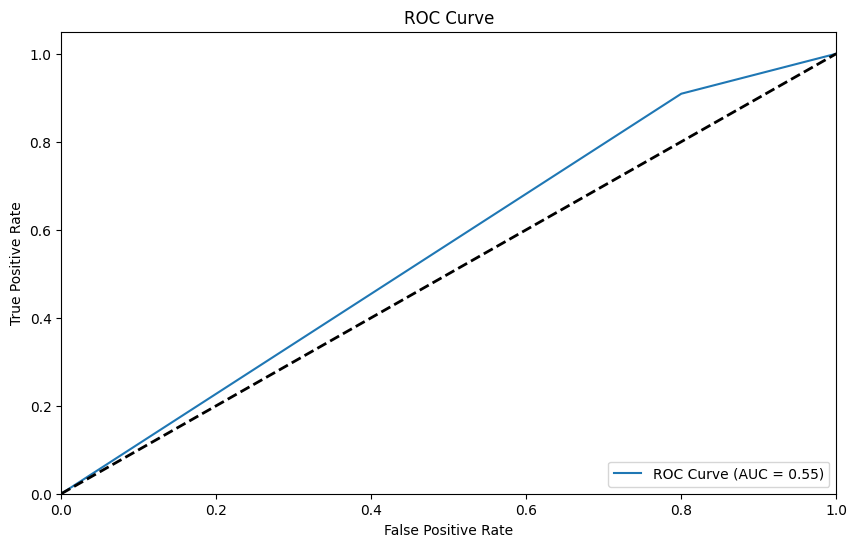

In [ ]:
Testing(best_model, test_ds)

In [ ]:
torch.save(best_model, 'model_final_weights.pth')